## 0. Introduction

The aim of this lab is to get familiar with **classification problems** and **logistic regression**. We will be using some code extracts that were implemented last week and build a logistic regression model.

1.   This lab is the second course-work activity **Assignment 1 Part 2: Classification**
2. Assignment 1 is split into 3 parts: Part 1 - Regression (Lab 3), and Part 2 - Classification (Lab 4) and Part 3 - Neural Networks (Lab 6). The three parts need to be submitted together by  **Monday, 11th November 2024, 10:00am**
3. All questions need to be completed and are assessed.
4. For each lab, a report answering the <font color = 'red'>**questions in red**</font> should be included along with the completed Notebook (.ipynb)
5. The report should be a separate file in **pdf format** (so **NOT** *doc, docx, notebook* etc.).
6. Make sure that **any figures or code** you comment on, are **included in the report**.
7. There are three parts of Assignment 1, therefore you should submit a zip file that contains 1 x Notebook and 1 x PDF for each part. In total: 3 x Notebooks and 3 x PDFs in the submission zip. Make sure the file is well identified with your name, student number, assignment number (for instance, Assignment 1), module code.
7. No other means of submission other than the appropriate QM+ link is acceptable at any time (so NO email attachments, etc.)
8. **PLAGIARISM** <ins>is an irreversible non-negotiable failure in the course</ins> (if in doubt of what constitutes plagiarism, ask!).


For this lab, we will be using the [iris dataset](https://scikit-learn.org/stable/datasets/toy_dataset.html#iris-dataset).

In [ ]:
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from sklearn import model_selection
from sklearn import datasets
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
from IPython import display

import typing
%matplotlib inline

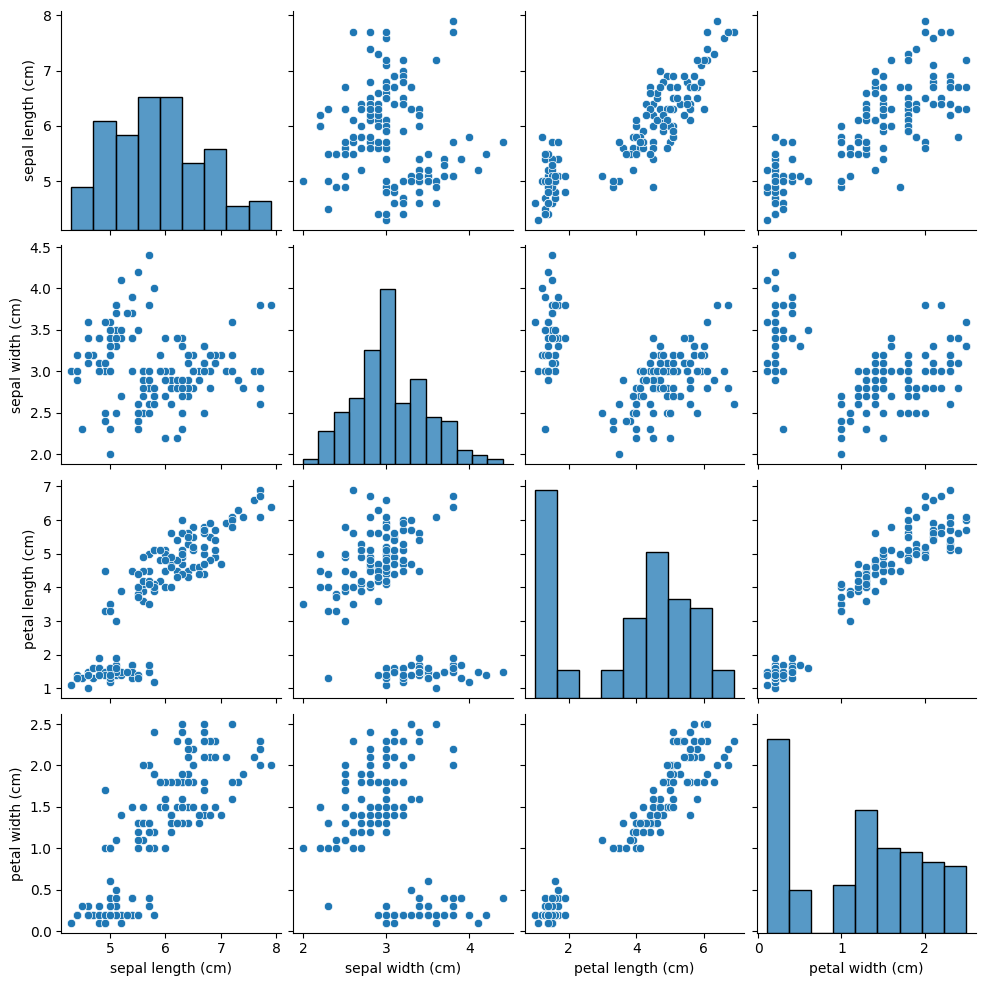

In [ ]:
iris_db = datasets.load_iris(as_frame=True)
sn.pairplot(iris_db.data)

In [ ]:
iris_db.data.head(10)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
5,5.4,3.9,1.7,0.4
6,4.6,3.4,1.4,0.3
7,5.0,3.4,1.5,0.2
8,4.4,2.9,1.4,0.2
9,4.9,3.1,1.5,0.1


We will split the data into train and test sets. For consistency and to allow for meaningful comparison the same splits are maintained in the remainder of the lab.

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    iris_db.data,
    iris_db.target,
    test_size=0.2,
    random_state=42
    )
x_train = torch.from_numpy(X_train.values).float()
x_test = torch.from_numpy(X_test.values).float()

y_train = torch.from_numpy(y_train.values).int()
y_train = y_train.reshape(-1, 1)

y_test = torch.from_numpy(y_test.values).int()
y_test = y_test.reshape(-1, 1)

<font color="red">**Q1.** We again notice that the attributes are on different scales. Use the normalisation method from last lab, to standardize the scales of each attribute on both sets. Plot the normalized and raw training sets; what do you observe? [2 marks] </font>

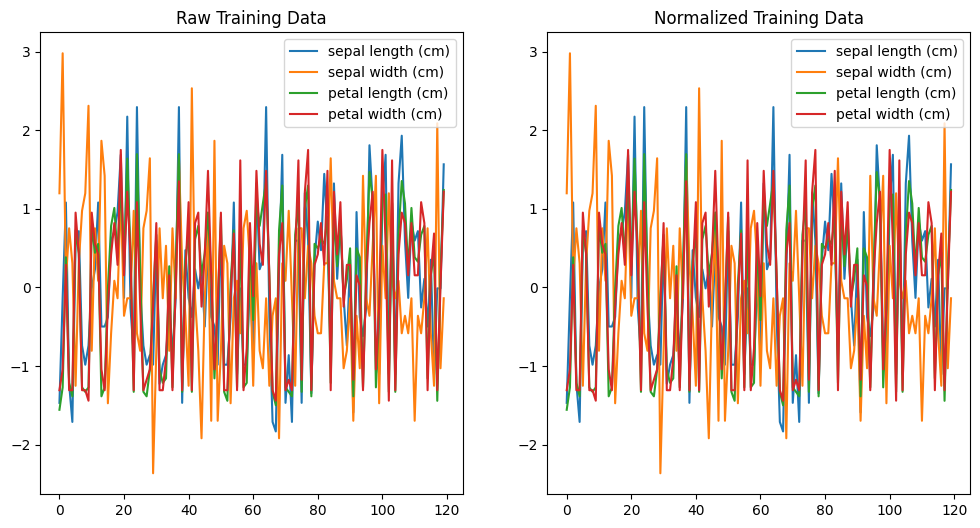

In [ ]:
### your code here

def norm_set(x: torch.Tensor, mu: torch.Tensor, sigma: torch.Tensor) -> torch.tensor:
  ### your code here
  n_set = (x - mu) / sigma
  #print("n_set is:", n_set)
  return n_set

mu = x_train.mean(dim=0)
sigma = x_train.std(dim=0)

x_train_normalized = norm_set(x_train, mu, sigma)
x_test_normalized = norm_set(x_test, mu, sigma)


#print("Mean of normalized training data (should be close to 0):")
#print(x_train_normalized.mean(dim=0))

#print("\nStandard deviation of normalized training data (should be close to 1):")
#print(x_train_normalized.std(dim=0))


X_train_df = pd.DataFrame(x_train.numpy(), columns=iris_db.data.columns)
X_train_normalized_df = pd.DataFrame(x_train_normalized.numpy(), columns=iris_db.data.columns)


plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
plt.title("Raw Training Data")
plt.plot(X_train_df, label=X_train_df.columns)
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.title("Normalized Training Data")
plt.plot(X_train_normalized_df, label=X_train_normalized_df.columns)
plt.legend(loc='upper right')

plt.show()

x_train = x_train_normalized
x_test = x_test_normalized

By inspecting the dataset we see that it contains 4 attributes. (`sepal length`, `sepal width`, `petal length`, `petal width`, in centimeters). For simplicity we will focus on the first two.

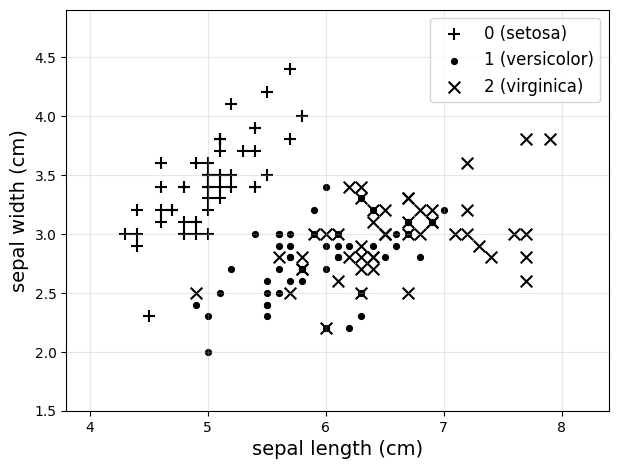

In [ ]:
X = iris_db.data.iloc[:, :2]
Y = iris_db.target
marker_list = ['+', '.', 'x']
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)
ax.set_aspect('equal')

for l in [0, 1, 2]:
  ax.scatter(
      X.loc[Y == l].iloc[:, 0],
      X.loc[Y == l].iloc[:, 1],
      marker=marker_list[l],
      s=70,
      color='black',
      label='{:d} ({:s})'.format(l, iris_db.target_names[l])
      )

ax.legend(fontsize=12)
ax.set_xlabel(iris_db.feature_names[0], fontsize=14)
ax.set_ylabel(iris_db.feature_names[1], fontsize=14)
ax.grid(alpha=0.3)
ax.set_xlim(X.iloc[:, 0].min() - 0.5, X.iloc[:, 0].max() + 0.5)
ax.set_ylim(X.iloc[:, 1].min() - 0.5, X.iloc[:, 1].max() + 0.5)
plt.show()

Is the data linearly separable? => **No the data is not linearly seperable **

As there are multiple classes, for now we will focus on class 0 (setosa). As such, we modify the `y_train` and `y_test` tensors, so that each label is 1 if the class is setosa and 0 if otherwise.

In [ ]:
train_set_1 = x_train[:, :2]
test_set_1 = x_test[:, :2]

# add a feature for bias
train_set_1 = torch.cat([train_set_1, torch.ones(train_set_1.shape[0], 1)], dim=1)
test_set_1 = torch.cat([test_set_1, torch.ones(test_set_1.shape[0], 1)], dim=1)

setosa_train = (y_train == 0).int()
setosa_test = (y_test == 0).int()

## 1. Sigmoid function
With logistic regression the values we want to predict are now discrete classes, not continuous variables. In other words, logistic regression is for classification tasks. In the binary classification problem we have classes $0$ and $1$, e.g. classifying email as spam or not spam based on words used in the email.

The logistic/sigmoid function given by the formula below:

$ h_{\theta}(x) = g(\theta^{T}x) =  \frac{1}{1+ e^{-\theta^Tx}} $

**Q2.** First implement the above function in `def sigmoid()`. [2 marks]

**Q3.** Then, using the implementation of `LinearRegression` from last week as guideline, create a custom pytorch layer for `LogisticRegression` [2 marks]

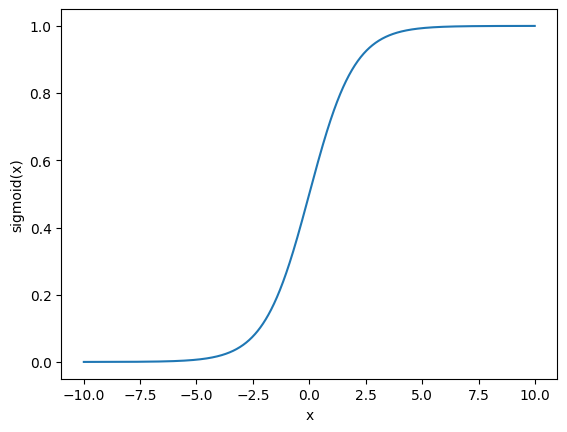

In [ ]:
def sigmoid(z: torch.Tensor) -> torch.Tensor:
  ### your code here
  z = 1 / (1 + torch.exp(-z))
  return z


x = torch.arange(1,2000, 1)/100.0 - 10
y = sigmoid(x)
fig, ax1 = plt.subplots()
ax1.plot(x, y)
ax1.set_xlabel('x')

ax1.set_ylabel('sigmoid(x)')
plt.show()

In [ ]:
class LogisticRegression(nn.Module):
  def __init__(self, num_features):
    super().__init__()
    self.weight = nn.Parameter(torch.zeros(1, num_features), requires_grad=False)

  def forward(self, x):
    y = 0
    ### your code here
    linear_output = torch.matmul(x, self.weight.T)  # Linear component θᵀx
    y = sigmoid(linear_output)  # Sigmoid to get probabilities
    return y

The cost function we will use for logistic regression is the **Cross Entropy Loss**, which is given by the form:

$J(\theta) = \frac{1}{m} \sum_{i=1}^m \left[ \left(- y^{(i)} log( h_{\theta}(x^{(i)})) - (1-y^{(i)})log(1-h_{\theta}(x^{(i)}))    \right) \right] $

Which when taking partial derivatives and putting these into the gradient descent update equation gives


$
 \theta_{j} =  \theta_{j} - \alpha \frac{1}{m}  \sum_{i=1}^m ( h_{\theta}(x^{(i)}) - y^{(i)})x^{(i)}_{j}
$

**Q4.** Implement the cost in `bce()` and update the `gradient_descent_step()` from last week to update using the partial derivative above. [4 marks]

In [ ]:
def bce(y_true: torch.Tensor, y_pred: torch.Tensor) -> torch.Tensor:
    y_pred = torch.clamp(y_pred, min=1e-7, max=1 - 1e-7)
    loss = -torch.mean(y_true * torch.log(y_pred) + (1 - y_true) * torch.log(1 - y_pred))
    return loss

def gradient_descent_step(model: nn.Module, X: torch.Tensor, y: torch.Tensor, lr: float) -> None:
    weight = model.weight
    N = X.shape[0]  # Number of samples
    y_pred = model(X)
    grad = (1 / N) * torch.matmul((y_pred - y).T, X)


    weight = weight - lr * grad


    model.weight = nn.Parameter(weight, requires_grad=False)

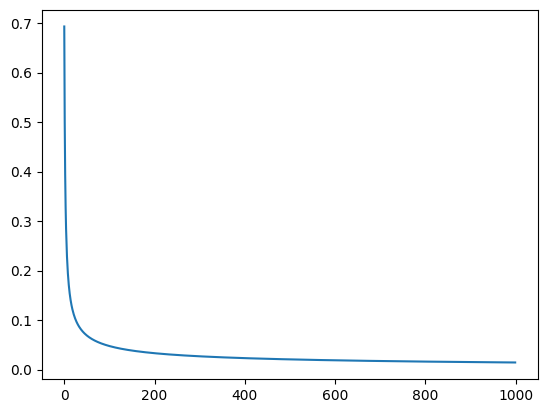

Parameter containing:
tensor([[-7.6483,  4.1452, -4.5710]])
Minimum cost: 0.014265166595578194


In [ ]:

def train(model, x, y, alpha):
  cost_lst = list()
  for it in range(1000):
    prediction = model(x)
    cost = bce(y, prediction)
    cost_lst.append(cost)
    gradient_descent_step(model, x, y, alpha)
  display.clear_output(wait=True)
  plt.plot(list(range(it+1)), cost_lst)
  plt.show()
  print(model.weight)
  print('Minimum cost: {}'.format(min(cost_lst)))

model = LogisticRegression(train_set_1.shape[1])
alpha = 1 # select an appropriate lr
train(model, train_set_1, setosa_train, alpha)

<font color="red"> **Q5.** Draw the decision boundary on the test set using the learned parameters. Is this decision boundary separating the classes? Does this match our expectations? [2 marks]</font>

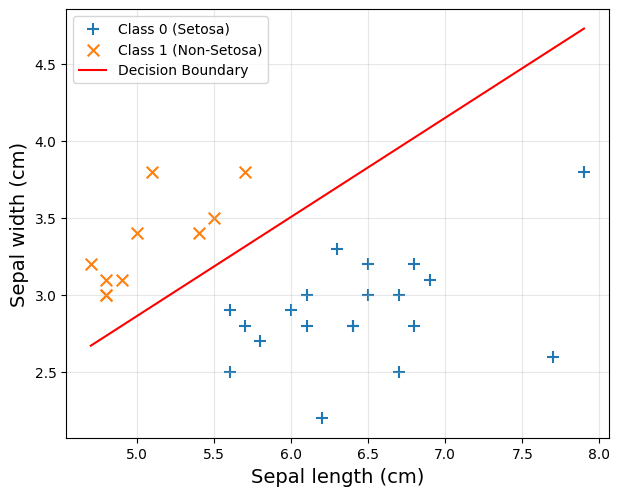

In [ ]:
def plot_decision_boundary(model, X, y):
    w = model.weight.detach().numpy()[0]

    fig, ax = plt.subplots(figsize=(7, 7))
    ax.set_aspect('equal')

    marker_list = ['+', 'x']
    for l in [0, 1]:  # Only 2 classes (Setosa and Non-Setosa)
        class_indices = np.where(y == l)[0]
        class_X = X[class_indices]

        ax.scatter(
            class_X[:, 0],
            class_X[:, 1],
            marker=marker_list[l],
            s=70,
            label=f'Class {l} ({"Setosa" if l == 0 else "Non-Setosa"})'
        )


    x_vals = torch.linspace(X[:, 0].min(), X[:, 0].max(), 100).numpy()
    y_vals = -(w[0] * x_vals + w[2]) / w[1]

    ax.plot(x_vals, y_vals, label="Decision Boundary", color="red")

    ax.set_xlabel("Sepal length (cm)", fontsize=14)
    ax.set_ylabel("Sepal width (cm)", fontsize=14)
    ax.legend()
    ax.grid(alpha=0.3)
    plt.show()

plot_decision_boundary(model, test_set_1[:, :2].numpy(), setosa_test.numpy())


## 2. Multiclass
So far, we have focused on a binary classification (is this iris setosa or not), however in this section we will address the problem as a multiclass classification. We will be using a 1 vs. all approach (refer to the lecture notes for details). We will also be using all 4 attributes for the classification.

Firstly, we need to process `y_train, y_test` so that each label is a vector rather than an integer.

In [ ]:
y_train = F.one_hot(y_train.reshape(-1).long(), num_classes=3)
y_test = F.one_hot(y_test.reshape(-1).long(), num_classes=3)
print(y_test.shape)

torch.Size([30, 3])


In this section we will use the built in pytorch methods.


In [ ]:
alpha = 0.1
setosa_model = nn.Sequential(nn.Linear(x_train.shape[1], 1, bias=False), nn.Sigmoid())
setosa_labels = y_train[:, 0].reshape(-1, 1).float()
setosa_testy = y_test[:, 0].reshape(-1, 1).float()
optimiser = optim.SGD(setosa_model.parameters(), alpha)

def train(model, x, y, test_x, test_y, optimiser, alpha):
  train_lst = list()
  test_lst = list()
  for i in range(1000):
    model.train()
    optimiser.zero_grad()
    pred = model(x)
    cost = F.binary_cross_entropy(pred, y, reduction='mean')
    cost.backward()
    train_lst.append(cost.item())
    optimiser.step()
    model.eval()
    with torch.no_grad():
      test_pred = model(test_x)
      test_cost = F.binary_cross_entropy(test_pred, test_y, reduction='mean')
      test_lst.append(test_cost)
  fig, axs = plt.subplots(2)
  axs[0].plot(list(range(i+1)), train_lst)
  axs[1].plot(list(range(i+1)), test_lst)
  plt.show()
  print('Minimum train cost: {}'.format(min(train_lst)))
  print('Minimum test cost: {}'.format(min(test_lst)))


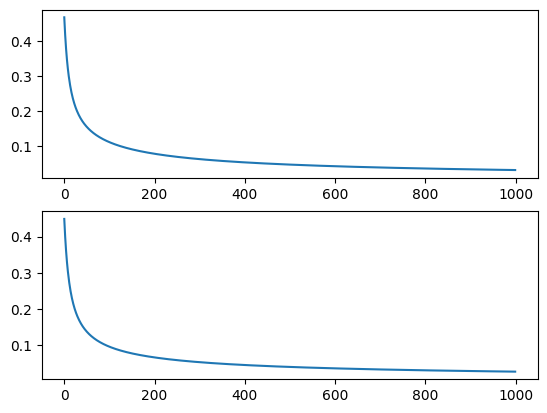

Minimum train cost: 0.03090403601527214
Minimum test cost: 0.026708142831921577


In [ ]:
train(setosa_model, x_train, setosa_labels, x_test, setosa_testy, optimiser, alpha)

How does the cost of the 4 attribute model compare to the previous one?

**Q6** Now train classifiers for the other two classes.[1 mark]

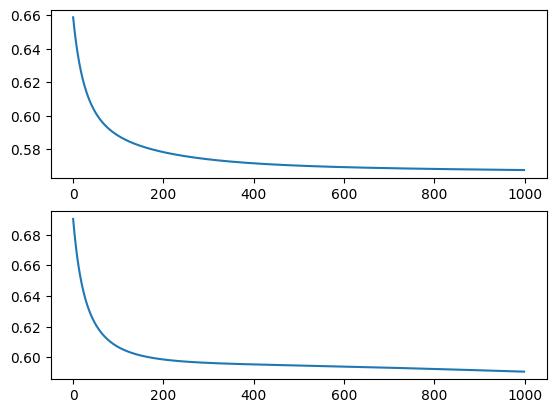

Minimum train cost: 0.5675182342529297
Minimum test cost: 0.5906448364257812


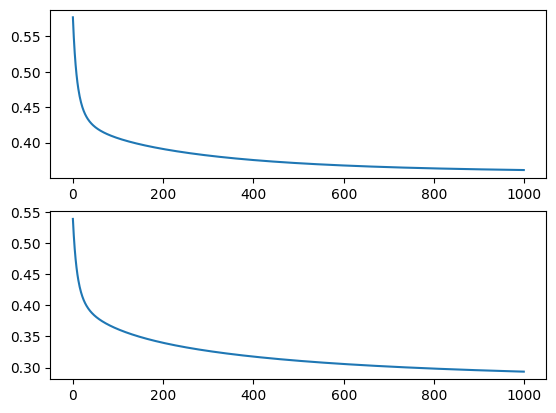

Minimum train cost: 0.36112672090530396
Minimum test cost: 0.29334887862205505


In [ ]:
### your code here

# Versicolor model (class 1)
versicolor_model = nn.Sequential(nn.Linear(x_train.shape[1], 1, bias=False), nn.Sigmoid())
versicolor_labels = y_train[:, 1].reshape(-1, 1).float()
versicolor_testy = y_test[:, 1].reshape(-1, 1).float()
optimiser_versicolor = optim.SGD(versicolor_model.parameters(), alpha)

# Virginica model (class 2)
virginica_model = nn.Sequential(nn.Linear(x_train.shape[1], 1, bias=False), nn.Sigmoid())
virginica_labels = y_train[:, 2].reshape(-1, 1).float()
virginica_testy = y_test[:, 2].reshape(-1, 1).float()
optimiser_virginica = optim.SGD(virginica_model.parameters(), alpha)

# Train the Versicolor model
train(versicolor_model, x_train, versicolor_labels, x_test, versicolor_testy, optimiser_versicolor, alpha)

# Train the Virginica model
train(virginica_model, x_train, virginica_labels, x_test, virginica_testy, optimiser_virginica, alpha)


<font color="red"> **Q7.** Using the 3 classifiers, predict the classes of the samples in the test set and show the predictions in a table. Do you observe anything interesting? [4 marks] </font>

In [ ]:
import pandas as pd


def predict_classes(setosa_model, versicolor_model, virginica_model, x_test, y_test):
    setosa_preds = setosa_model(x_test).detach().numpy().flatten()
    versicolor_preds = versicolor_model(x_test).detach().numpy().flatten()
    virginica_preds = virginica_model(x_test).detach().numpy().flatten()
    predictions_df = pd.DataFrame({
        'Setosa Confidence': setosa_preds,
        'Versicolor Confidence': versicolor_preds,
        'Virginica Confidence': virginica_preds,
    })


    predictions_df['Predicted Class'] = predictions_df[['Setosa Confidence', 'Versicolor Confidence', 'Virginica Confidence']].idxmax(axis=1)
    predictions_df['Predicted Class'] = predictions_df['Predicted Class'].apply(lambda x: x.split()[0])


    ground_truth_classes = torch.argmax(y_test, dim=1).numpy()
    class_names = ['Setosa', 'Versicolor', 'Virginica']
    predictions_df['Ground Truth Class'] = [class_names[label] for label in ground_truth_classes]

    return predictions_df


predictions_df = predict_classes(setosa_model, versicolor_model, virginica_model, x_test, y_test)
print(predictions_df[['Setosa Confidence', 'Versicolor Confidence', 'Virginica Confidence', 'Predicted Class', 'Ground Truth Class']].to_string(index=False))


 Setosa Confidence  Versicolor Confidence  Virginica Confidence Predicted Class Ground Truth Class
          0.034410               0.742355              0.457444      Versicolor         Versicolor
          0.999964               0.170519              0.110957          Setosa             Setosa
          0.000003               0.838924              0.946857       Virginica          Virginica
          0.036972               0.590232              0.705695       Virginica         Versicolor
          0.009189               0.765599              0.535546      Versicolor         Versicolor
          0.999706               0.314759              0.081546          Setosa             Setosa
          0.281754               0.547601              0.528553      Versicolor         Versicolor
          0.002073               0.376506              0.968881       Virginica          Virginica
          0.000522               0.914940              0.389690      Versicolor         Versicolor
          

<font color="red"> **Q8.** Calculate the accuracy of the classifier on the test set, by comparing the predicted values against the ground truth. Use a softmax for the classifier outputs. [1 mark] </font>

In [ ]:
import torch
import torch.nn.functional as F

def calculate_accuracy(model, x, y_true):
    model.eval()
    with torch.no_grad():

        y_pred = F.softmax(model(x), dim=1)
        preds = y_pred.argmax(dim=1)
        accuracy = (preds == y_true).float().mean().item()
    return accuracy

setosa_accuracy = calculate_accuracy(setosa_model, x_test, setosa_testy)
print(f"Setosa classifier accuracy: {setosa_accuracy * 100:.2f}%")

versicolor_accuracy = calculate_accuracy(versicolor_model, x_test, versicolor_testy)
print(f"Versicolor classifier accuracy: {versicolor_accuracy * 100:.2f}%")

virginica_accuracy = calculate_accuracy(virginica_model, x_test, virginica_testy)
print(f"Virginica classifier accuracy: {virginica_accuracy * 100:.2f}%")


Setosa classifier accuracy: 66.67%
Versicolor classifier accuracy: 70.00%
Virginica classifier accuracy: 63.33%


In [ ]:
import torch
import torch.nn.functional as F
import numpy as np

# Function to calculate accuracy using softmax across classifiers
def calculate_softmax_accuracy(setosa_model, versicolor_model, virginica_model, x_test, y_test):
    # Collect predictions from each one-vs-all model for each class
    setosa_preds = setosa_model(x_test).detach().numpy().flatten()
    versicolor_preds = versicolor_model(x_test).detach().numpy().flatten()
    virginica_preds = virginica_model(x_test).detach().numpy().flatten()

    # Stack the predictions to create a matrix of shape (num_samples, 3)
    stacked_preds = np.stack([setosa_preds, versicolor_preds, virginica_preds], axis=1)

    # Apply softmax across the class predictions for each sample
    softmax_preds = F.softmax(torch.tensor(stacked_preds), dim=1).numpy()

    # Get the predicted class by choosing the class with the highest probability
    predicted_classes = np.argmax(softmax_preds, axis=1)

    # Convert y_test (ground truth) to class labels (0 for Setosa, 1 for Versicolor, 2 for Virginica)
    ground_truth_classes = torch.argmax(y_test, dim=1).numpy()

    # Calculate the accuracy by comparing predictions to ground truth
    accuracy = np.mean(predicted_classes == ground_truth_classes)

    return accuracy

# Usage
# Calculate accuracy on the test set
test_accuracy = calculate_softmax_accuracy(setosa_model, versicolor_model, virginica_model, x_test, y_test)
print(f"Test set accuracy using softmax: {test_accuracy * 100:.2f}%")


Test set accuracy using softmax: 90.00%


## 3. The XOR problem

<font color="red"> **Q9.** Looking at the datapoints below, can we draw a decision boundary using Logistic Regression? Why? What are the specific issues or logistic regression with regards to XOR? [2 marks] </font>

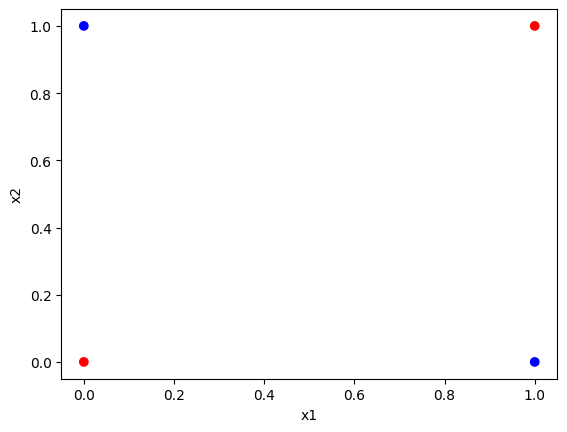

In [ ]:
x1 = [0, 0, 1, 1]
x2 = [0, 1, 0, 1]
y = [0, 1, 1, 0]

c_map = ['r', 'b', 'b', 'r']
plt.scatter(x1, x2, c=c_map)
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()